In [1]:
# Benchmark Setup (please run this setup cell and corresponding data cells before benchmarks)

import scanpy as sc
import leidenalg
import tsKNEE
import os
import subprocess

### Set Input Data ###
adata = sc.read_h5ad("../small_test_data/small_test_data1.h5ad")
# adata = sc.read_h5ad("../big_test_data/big_test_data.h5ad") [larger dataset causes memory issues]
######################

current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
path_to_memusg = os.path.join(parent_dir, 'memusg', 'memusg')
os.chmod(path_to_memusg, 0o755)
os.environ['PATH'] += os.pathsep + os.path.dirname(path_to_memusg)

def run_memusg(command):
    result = subprocess.run([path_to_memusg] + command.split(), capture_output=True, text=True)
    print(result.stdout)
    print(result.stderr)
    if result.returncode != 0:
        print(f"Return code: {result.returncode}")
        raise RuntimeError(f"Command failed with return code {result.returncode}")
    return result.stdout


## Continuity acore benchmark setup
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances

def continuity_score(X_high, X_low, n_neighbors=5):
    """
    Compute the continuity score of the low-dimensional embedding.

    Parameters:
    X_high : array-like, shape (n_samples, n_features)
        High-dimensional data.
    X_low : array-like, shape (n_samples, n_components)
        Low-dimensional embedding.
    n_neighbors : int, optional, default: 5
        Number of nearest neighbors to consider.

    Returns:
    continuity : float
        Continuity score.
    """
    n_samples = X_high.shape[0]

    # Find nearest neighbors in high-dimensional space
    nbrs_high = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(X_high)
    distances_high, indices_high = nbrs_high.kneighbors(X_high)

    # Find nearest neighbors in low-dimensional space
    nbrs_low = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(X_low)
    distances_low, indices_low = nbrs_low.kneighbors(X_low)

    # Remove self-indices (first column)
    indices_high = indices_high[:, 1:]
    indices_low = indices_low[:, 1:]

    # Compute continuity score
    continuity = 0
    for i in range(n_samples):
        intersection = len(set(indices_high[i]).intersection(set(indices_low[i])))
        continuity += intersection / n_neighbors

    continuity /= n_samples
    return continuity

In [2]:
# Prepare data for Compute Benchmark
sc.pp.neighbors(adata, use_rep='X')
sc.tl.leiden(adata)
adata_file = 'adata.h5ad'
adata.write(adata_file)

In [3]:
# Prepare data for Memory Benchmark
adata_tsne = adata.copy()
sc.tl.tsne(adata_tsne, use_rep='X')
adata_tsne_file = 'adata_tsne.h5ad'
adata_tsne.write(adata_tsne_file)

adata_tsknee = adata.copy()
tsKNEE.tsKNEE(adata_tsknee)
adata_tsknee_file = 'adata_tsknee.h5ad'
adata_tsknee.write(adata_tsknee_file)

In [4]:
print('# Compute Benchmark of Dimensional Reduction')

print('tsKNEE')
adata = sc.read_h5ad(adata_file)
%time x = tsKNEE.tsKNEE(adata)

print('tSNE')
adata = sc.read_h5ad(adata_file)
%time sc.tl.tsne(adata, use_rep='X')

# Compute Benchmark of Dimensional Reduction
tsKNEE
CPU times: user 857 ms, sys: 5.99 ms, total: 863 ms
Wall time: 862 ms
tSNE
CPU times: user 2.98 s, sys: 12.1 ms, total: 2.99 s
Wall time: 387 ms


# Compute Benchmark of Plotting
tsKNEE


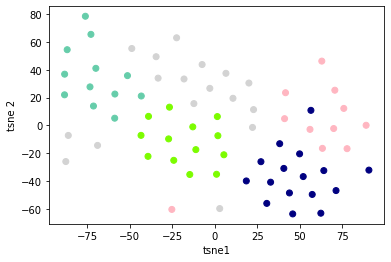

CPU times: user 119 ms, sys: 4.14 ms, total: 123 ms
Wall time: 123 ms
tSNE


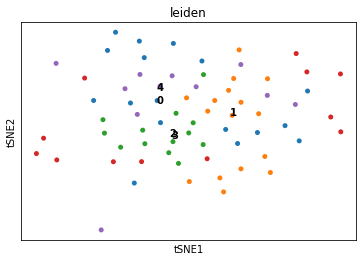

CPU times: user 61 ms, sys: 2.01 ms, total: 63 ms
Wall time: 63 ms


In [5]:
print('# Compute Benchmark of Plotting')

print('tsKNEE')
adata_tsknee = sc.read_h5ad(adata_tsknee_file)
%time tsKNEE.tsKNEE_plot(adata_tsknee)

print('tSNE')
adata_tsne = sc.read_h5ad(adata_tsne_file)
%time sc.pl.tsne(adata_tsne, color=['leiden'], legend_loc='on data', legend_fontsize=10, size=100)

In [6]:
print('# Memory Benchmark of Dimensional Reduction')

print('tsKNEE')
tsknee_memusg_output = run_memusg(f'python -c "import scanpy as sc; from tsKNEE import tsKNEE; adata = sc.read(\'{adata_file}\'); tsKNEE(adata)"')
print(tsknee_memusg_output)

print('tSNE')
tsne_memusg_output = run_memusg(f'python -c "import scanpy as sc; adata = sc.read(\'{adata_file}\'); sc.tl.tsne(adata, use_rep=\'X\')"')
print(tsne_memusg_output)

# Memory Benchmark of Dimensional Reduction
tsKNEE

memusg: vmpeak: 18157948 kb


tSNE

memusg: vmpeak: 18666384 kb




In [7]:
print('# Memory Benchmark of Plotting')

print('tsKNEE')
tsknee_memusg_output = run_memusg(f'python -c "import scanpy as sc; from tsKNEE import tsKNEE_plot; adata_tsknee = sc.read(\'{adata_tsknee_file}\'); tsKNEE_plot(adata_tsknee)"')
print(tsknee_memusg_output)

print('tSNE')
tsne_memusg_output = run_memusg(f'python -c "import scanpy as sc; adata_tsne = sc.read(\'{adata_tsne_file}\'); sc.pl.tsne(adata_tsne, color=[\'leiden\'], legend_loc=\'on data\', legend_fontsize=10, size=100)"')
print(tsne_memusg_output)

# Memory Benchmark of Plotting
tsKNEE
Figure(640x480)

memusg: vmpeak: 18272028 kb

Figure(640x480)

tSNE
Figure(640x480)

memusg: vmpeak: 18272356 kb

Figure(640x480)



In [8]:
print('# Continuity Benchmark')

adata_tsknee = sc.read_h5ad(adata_file)
tsKNEE.tsKNEE(adata_tsknee)
tsknee_continuity = continuity_score(adata_tsknee.X, adata_tsknee.obsm['X_tsne'], n_neighbors=5)
print(f"tsKNEE continuity: {tsknee_continuity}")

adata_tsne = sc.read_h5ad(adata_tsne_file)
tsne_continuity = continuity_score(adata_tsne.X, adata_tsne.obsm['X_tsne'], n_neighbors=5)
print(f"tsne continuity: {tsne_continuity}")

# Continuity Benchmark
tsKNEE continuity: 0.5623188405797102
tsne continuity: 0.23188405797101447
